In [43]:
%%writefile kaggle.json
{"username":"srinivasapulyala","key":"4cda145f2d038535f18bb9a4d2ac42fa"}

Overwriting kaggle.json


In [44]:
# ============================================================
# Dataset Acquisition and Download
# ============================================================
import os

def download_kaggle_dataset(dataset_path):
    # Kaggle dataset path example: 'grassknoted/asl-alphabet'
    # Ensure Kaggle API is installed
    os.system('pip install -q kaggle')

    # Check for kaggle.json file
    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    # Set up Kaggle directory and permissions
    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Download the dataset
    os.system(f'kaggle datasets download -d {dataset_path}')

    # Unzip the dataset
    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

# Example Usage:
download_kaggle_dataset('shrutimechlearn/churn-modelling')

In [45]:
# ============================================================
# Load Dataset
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Churn_Modelling.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [46]:
#########################################
# Data Preprocessing and Feature Encoding
#########################################

# 1. Drop unnecessary columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True, errors='ignore')

# 2. Encode Gender (Female = 0, Male = 1)
df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

# 3. One-hot encode Geography
# drop_first=True removes France automatically as reference category
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# 4. Ensure Geography dummy columns are integers (safe practice)
geo_cols = [c for c in df.columns if c.startswith('Geography_')]
df[geo_cols] = df[geo_cols].astype(int)


In [47]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


In [48]:
######################################
#Experimental Setup and Reproducibility
#######################################
import os
import random
import numpy as np

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)


In [49]:
#########################################
# Visualisation Display and Result Interpretation
#########################################
def show_and_explain(observation_text: str, text_summary: str = "") -> None:
    """
    Display the current Matplotlib figure and print associated explanation.
    """

    # Show the current plot
    plt.show()

    # Print optional textual summary
    if text_summary:
        print("\nTextual Summary:")
        print(text_summary)

    # Print main observation
    print("\nObservation:")
    print(observation_text)


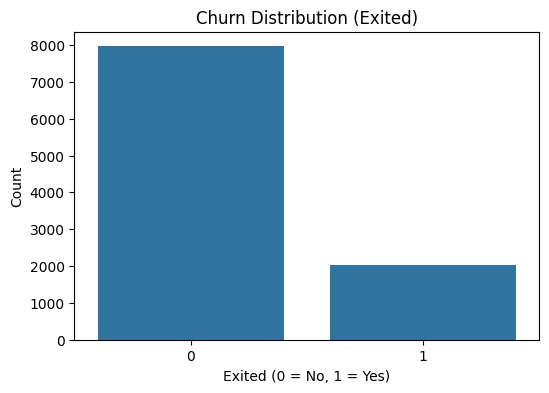


Observation:
The dataset shows class imbalance, with non-churn customers dominating.


In [50]:
#########################################
# EDA: Target Variable Distribution
#########################################

plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df)
plt.title("Churn Distribution (Exited)")
plt.xlabel("Exited (0 = No, 1 = Yes)")
plt.ylabel("Count")

show_and_explain(
    observation_text="The dataset shows class imbalance, with non-churn customers dominating.",
)


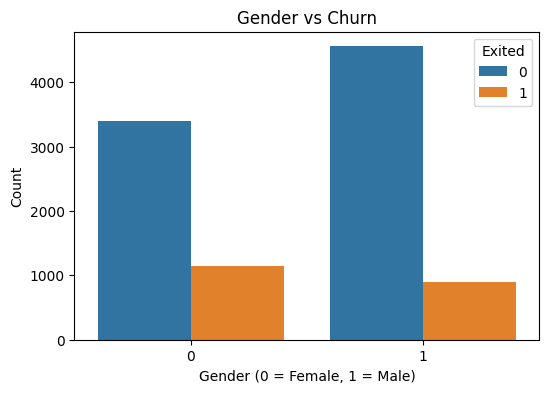


Observation:
Churn patterns differ slightly between genders, indicating gender may influence churn.


In [51]:
#########################################
# EDA: Gender vs Churn
#########################################

plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', hue='Exited', data=df)
plt.title("Gender vs Churn")
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Count")

show_and_explain(
    observation_text="Churn patterns differ slightly between genders, indicating gender may influence churn."
)


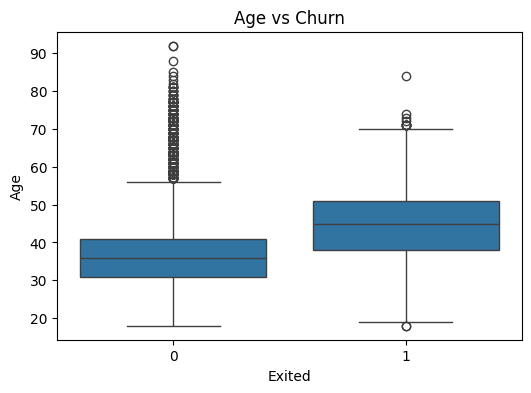


Observation:
Customers who churn tend to be older compared to those who stay.


In [52]:
#########################################
# EDA : Age vs Churn
#########################################

plt.figure(figsize=(6, 4))
sns.boxplot(x='Exited', y='Age', data=df)
plt.title("Age vs Churn")

show_and_explain(
    observation_text="Customers who churn tend to be older compared to those who stay."
)


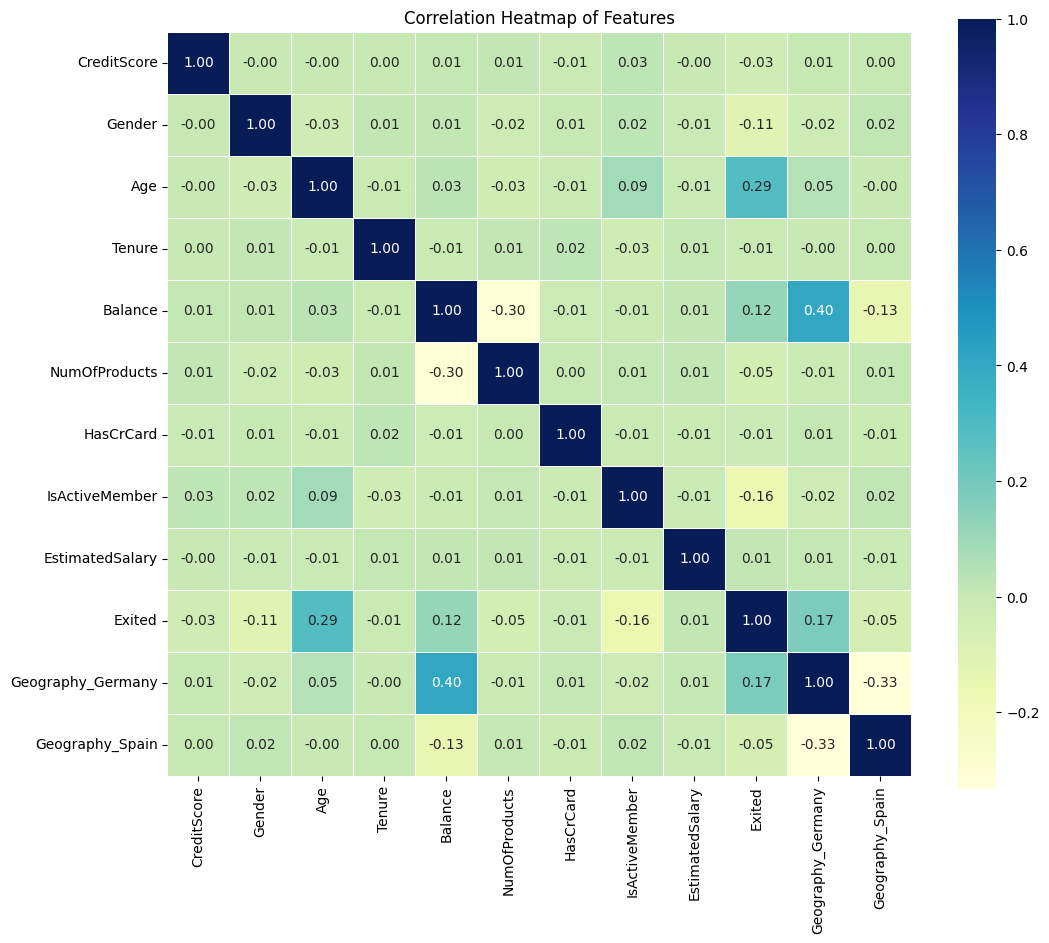


Observation:
Age and Balance show stronger correlations with churn compared to most other features.


In [53]:
#########################################
# EDA: Correlation Heatmap
#########################################

plt.figure(figsize=(12, 10))
corr = df.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu", square=True, linewidths=0.5)

plt.title("Correlation Heatmap of Features")

show_and_explain(
    observation_text="Age and Balance show stronger correlations with churn compared to most other features."
)



In [54]:
#########################################
# Feature–Target Split
#########################################

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Features (inputs)
X = df.drop(columns=['Exited'])

# Target (output)
y = df['Exited']

# Sanity check
print("Features shape:", X.shape)
print("Target shape:", y.shape)

#########################################
# Train–Test Split
#########################################

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#########################################
# Scaling
#########################################

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
feature_names = X.columns

#########################################
# SMOTE (only on training data)
#########################################

smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train_s, y_train)

#########################################
# Check class balance
#########################################

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_sm).value_counts())


Features shape: (10000, 11)
Target shape: (10000,)
Before SMOTE:
Exited
0    6370
1    1630
Name: count, dtype: int64

After SMOTE:
Exited
1    6370
0    6370
Name: count, dtype: int64


In [55]:
#########################################
# Model Evaluation and Performance Metrics
#########################################
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
results = []

def evaluate_model(model, X_test, y_test, model_name="Model"):
    # -----------------------------
    # 1) Get probabilities
    # -----------------------------
    if hasattr(model, "predict_proba"):  # sklearn models
        y_prob = model.predict_proba(X_test)[:, 1]
    else:  # ANN / Keras
        y_prob = model.predict(X_test, verbose=0).ravel()

    # -----------------------------
    # 2) Predictions
    # -----------------------------
    y_pred = (y_prob >= 0.5).astype(int)

    # -----------------------------
    # 3) Metrics
    # -----------------------------
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    print("=" * 60)
    print(f"Evaluation Results: {model_name}")
    print("=" * 60)
    print(f"Accuracy : {acc*100:.2f}%")
    print(f"Precision: {prec*100:.2f}%")
    print(f"Recall   : {rec*100:.2f}%")
    print(f"F1-score : {f1*100:.2f}%")
    print(f"ROC-AUC  : {auc*100:.2f}%")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, digits=3))

    # -----------------------------
    # 4) SIDE-BY-SIDE PLOTS
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Confusion Matrix (LEFT)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"Confusion Matrix - {model_name}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve (RIGHT)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    axes[1].set_title(f"ROC Curve - {model_name}")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 5) Return results
    # -----------------------------
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": auc
    }

Evaluation Results: Logistic Regression
Accuracy : 71.55%
Precision: 38.90%
Recall   : 69.78%
F1-score : 49.96%
ROC-AUC  : 77.69%

Classification Report:

              precision    recall  f1-score   support

           0      0.903     0.720     0.801      1593
           1      0.389     0.698     0.500       407

    accuracy                          0.716      2000
   macro avg      0.646     0.709     0.650      2000
weighted avg      0.799     0.716     0.740      2000



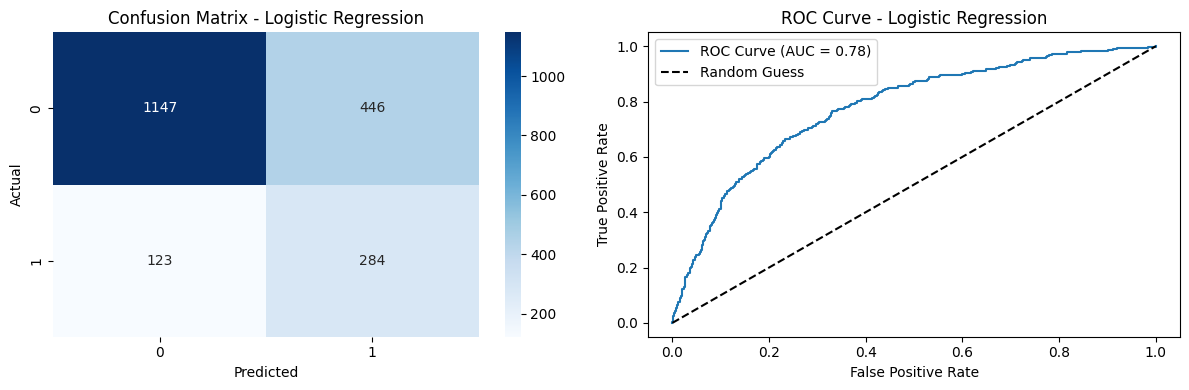

In [56]:
############################################################
# Evaluation Results: Logistic Regression
############################################################
from sklearn.linear_model import LogisticRegression

results = []

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_sm, y_train_sm)

results.append(evaluate_model(log_model, X_test_s, y_test, "Logistic Regression"))


Evaluation Results: Random Forest
Accuracy : 84.20%
Precision: 61.40%
Recall   : 60.20%
F1-score : 60.79%
ROC-AUC  : 85.01%

Classification Report:

              precision    recall  f1-score   support

           0      0.899     0.903     0.901      1593
           1      0.614     0.602     0.608       407

    accuracy                          0.842      2000
   macro avg      0.756     0.753     0.755      2000
weighted avg      0.841     0.842     0.841      2000



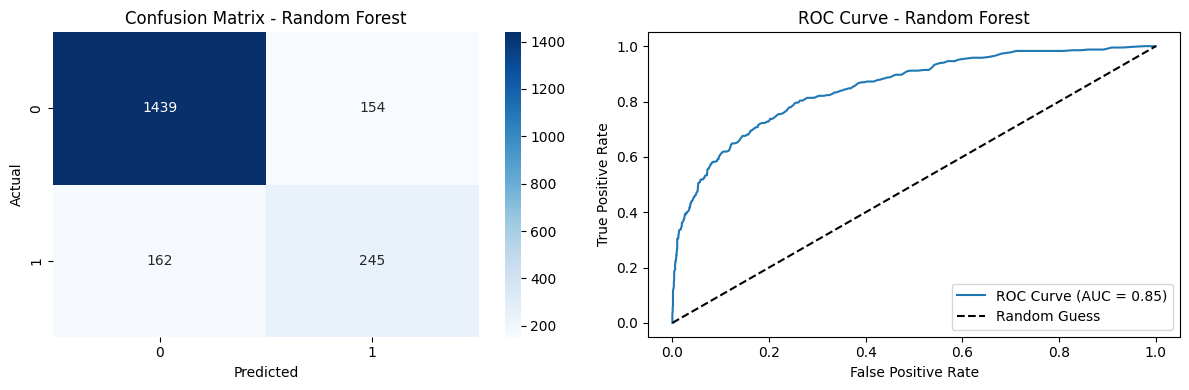

In [57]:
############################################################
# Evaluation Results: Random Forest
############################################################
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

results.append(evaluate_model(rf_model, X_test_s, y_test, "Random Forest"))


Evaluation Results: XGBoost
Accuracy : 85.55%
Precision: 65.69%
Recall   : 60.69%
F1-score : 63.09%
ROC-AUC  : 86.96%

Classification Report:

              precision    recall  f1-score   support

           0      0.901     0.919     0.910      1593
           1      0.657     0.607     0.631       407

    accuracy                          0.856      2000
   macro avg      0.779     0.763     0.771      2000
weighted avg      0.852     0.856     0.853      2000



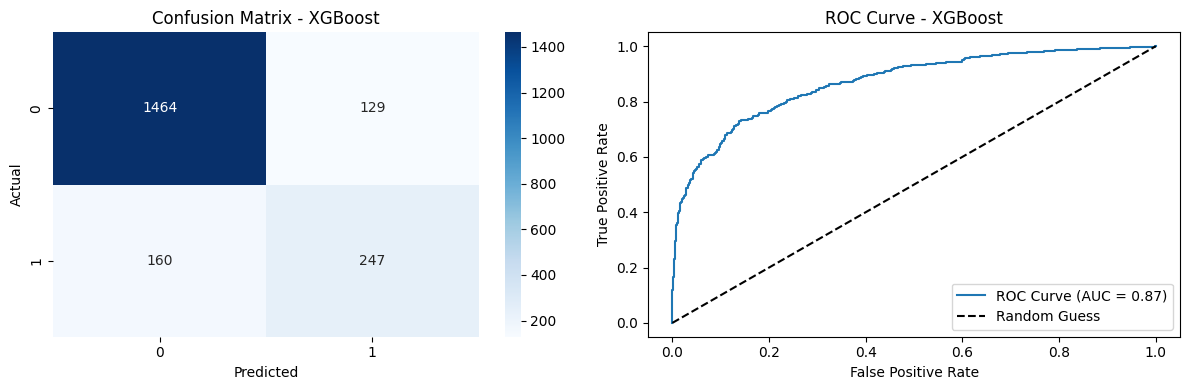

In [58]:
############################################################
# Evaluation Results: XGBoost
############################################################
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train_sm, y_train_sm)

results.append(evaluate_model(xgb_model, X_test_s, y_test, "XGBoost"))


[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluation Results: LightGBM
Accuracy : 85.85%
Precision: 69.25%
Recall   : 54.79%
F1-score : 61.18%
ROC-AUC  : 85.52%

Classification Report:

              precision    recall  f1-score   support

           0      0.890     0.938     0.913      1593
           1      0.693     0.548     0.612       407

    accuracy                          0.859      2000
   macro avg      0.791     0.743     0.763      2000
weighted avg      0.850     0.859     0.852      2000



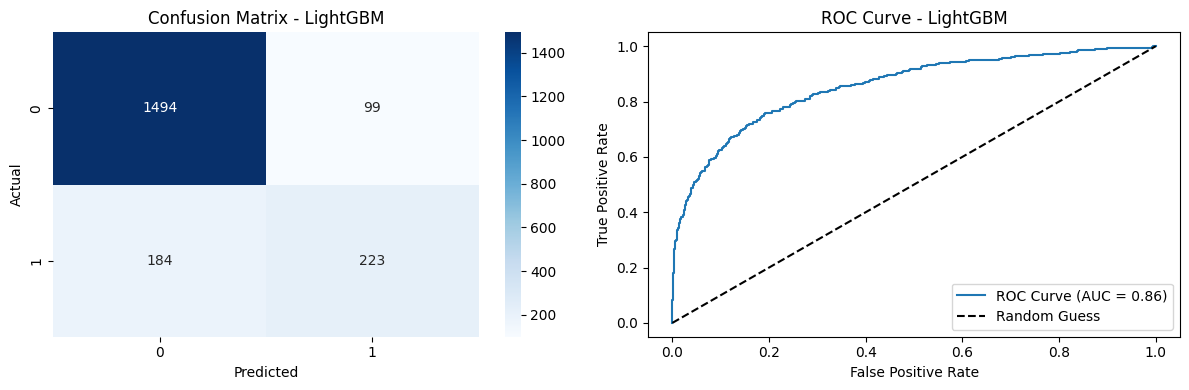

In [59]:
############################################################
# Evaluation Results: LightGBM
############################################################
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
lgbm_model.fit(X_train_sm, y_train_sm)

results.append(evaluate_model(lgbm_model, X_test_s, y_test, "LightGBM"))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Results: ANN
Accuracy : 83.25%
Precision: 57.76%
Recall   : 65.85%
F1-score : 61.54%
ROC-AUC  : 85.68%

Classification Report:

              precision    recall  f1-score   support

           0      0.910     0.877     0.893      1593
           1      0.578     0.658     0.615       407

    accuracy                          0.833      2000
   macro avg      0.744     0.768     0.754      2000
weighted avg      0.842     0.833     0.836      2000



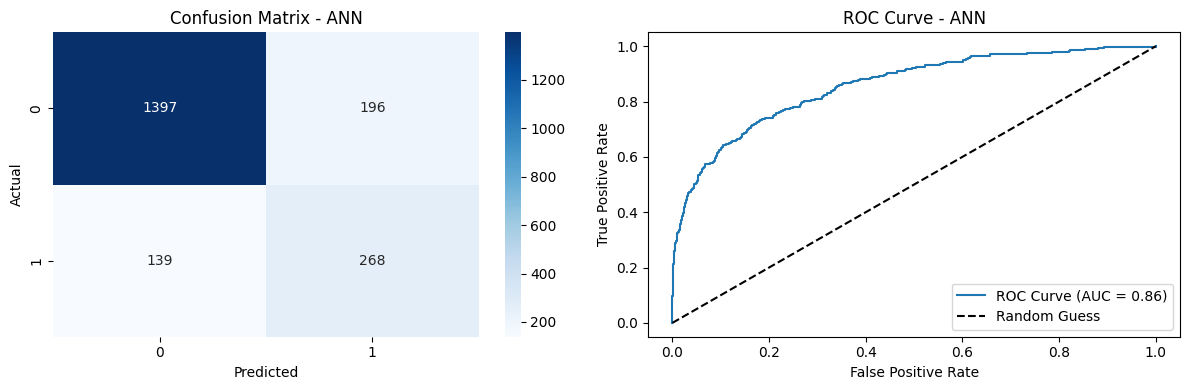

In [60]:
############################################################
# Evaluation Results: ANN
############################################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
import numpy as np
import tensorflow as tf


# Build ANN
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_sm.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train ANN
history = ann.fit(
    X_train_sm, y_train_sm,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate (using your unified evaluate_model function)
results.append(evaluate_model(ann, X_test_s, y_test, "ANN"))




=== Overall Model Comparison ===


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,XGBoost,0.8555,0.656915,0.606880,0.630907,0.869583
4,ANN,0.8325,0.577586,0.658477,0.615385,0.856769
3,LightGBM,0.8585,0.692547,0.547912,0.611797,0.855219
1,Random Forest,0.8420,0.614035,0.601966,0.607940,0.850071
0,Logistic Regression,0.7155,0.389041,0.697789,0.499560,0.776875


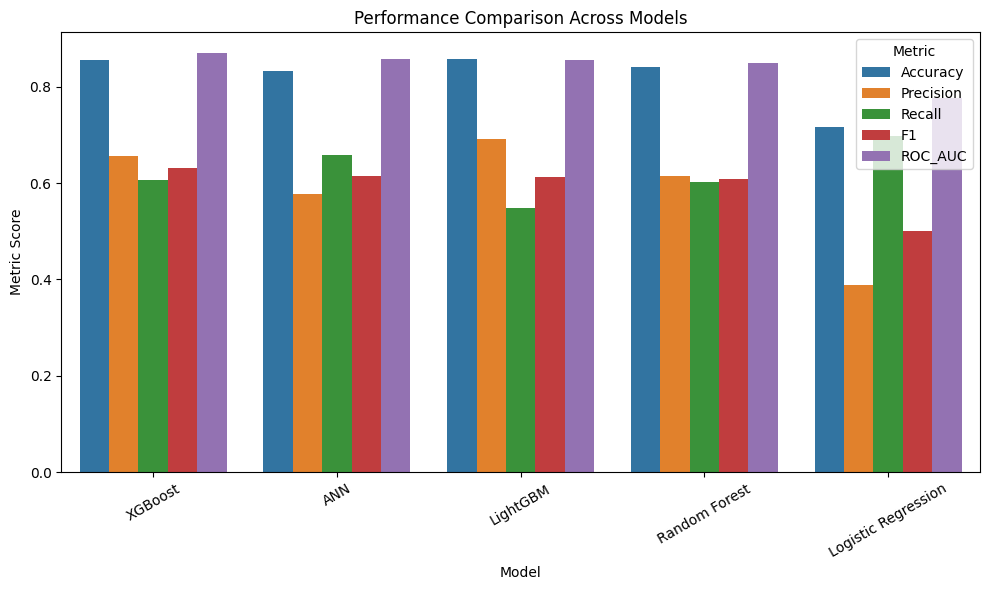

In [61]:
# ============================================================
#  Model Performance Comparison
# ============================================================

results_df = pd.DataFrame(results).sort_values(by='ROC_AUC', ascending=False)

print("\n=== Overall Model Comparison ===")
display(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df.melt(
        id_vars='Model',
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

    ),
    x='Model', y='value', hue='variable'
)

plt.title("Performance Comparison Across Models")
plt.ylabel("Metric Score")
plt.xticks(rotation=30)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


/tmp/ipython-input-396997697.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_shap, plot_type="bar")


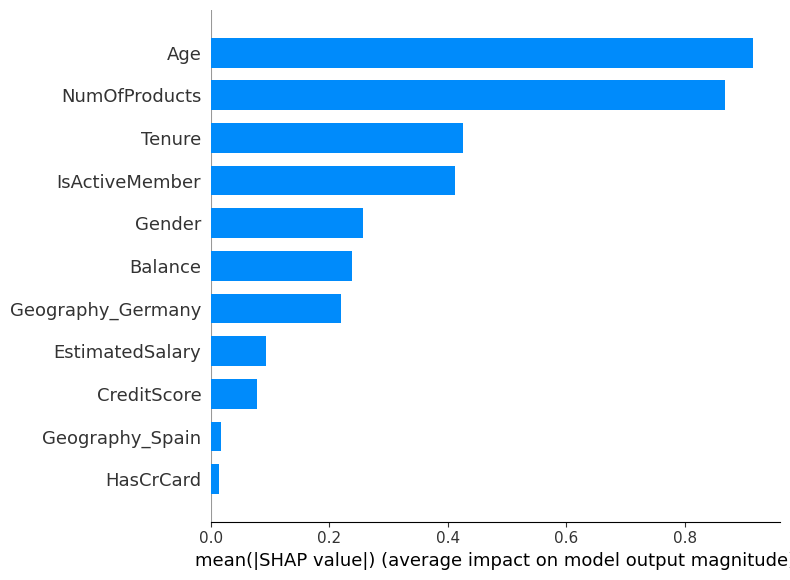

In [62]:
# =========================
#          SHAP
# =========================

import shap
import pandas as pd

# 1) Create a DataFrame from your scaled test set (X_test_s)
# IMPORTANT: columns must match the training feature names
X_test_shap = pd.DataFrame(X_test_s, columns=X.columns)

# 2) SHAP with your trained XGBoost model (xgb_model)
explainer = shap.TreeExplainer(xgb_model)

# 3) SHAP values (disable additivity check to avoid common error)
shap_values = explainer.shap_values(X_test_shap, check_additivity=False)

# 4) If SHAP returns list for binary classification, pick class 1
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 5) Plots
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")



Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Best CV ROC-AUC: 0.9610800361237359
Evaluation Results: XGBoost (Tuned)
Accuracy : 85.20%
Precision: 66.18%
Recall   : 55.77%
F1-score : 60.53%
ROC-AUC  : 84.69%

Classification Report:

              precision    recall  f1-score   support

           0      0.891     0.927     0.909      1593
           1      0.662     0.558     0.605       407

    accuracy                          0.852      2000
   macro avg      0.777     0.742     0.757      2000
weighted avg      0.845     0.852     0.847      2000



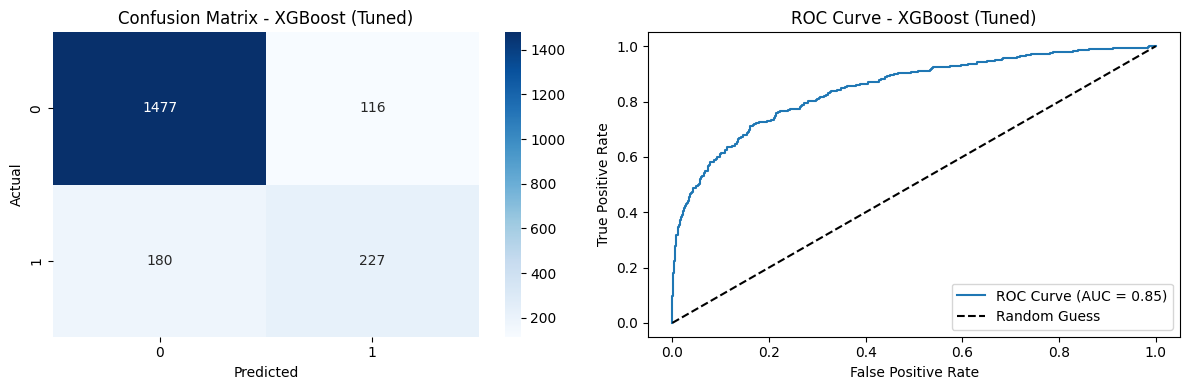


Generating SHAP (Tuned XGBoost) with baseline feature columns...


/tmp/ipython-input-1383725899.py:87: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, Xte_df, plot_type="bar", max_display=max_display)


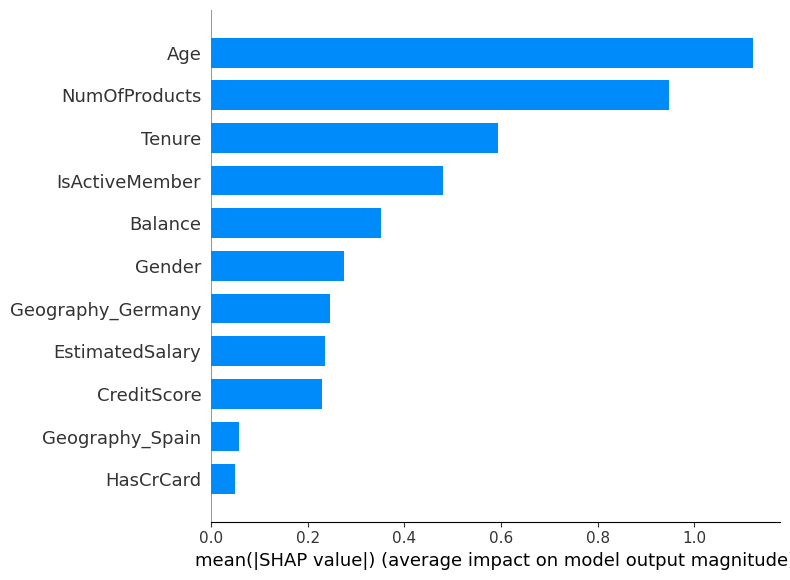

In [63]:
# =========================
# Hyperparameter Tuning
# =========================

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd
import shap


# Training (after SMOTE)
if "X_train_sm" in globals() and "y_train_sm" in globals():
    Xtr, ytr = X_train_sm, y_train_sm
elif "X_train_res" in globals() and "y_train_res" in globals():
    Xtr, ytr = X_train_res, y_train_res
else:
    raise NameError("Run your SMOTE cell first to create X_train_sm/y_train_sm (or X_train_res/y_train_res).")

# Test (scaled)
if "X_test_s" in globals():
    Xte = X_test_s
elif "X_test_scaled" in globals():
    Xte = X_test_scaled
else:
    raise NameError("Run your scaling cell first to create X_test_s (or X_test_scaled).")

if "y_test" not in globals():
    raise NameError("y_test not found. Run your train_test_split cell first.")

# Feature names (to force SAME SHAP columns as normal SHAP)
if "feature_names" in globals():
    feat_names = list(feature_names)
elif "X" in globals() and hasattr(X, "columns"):
    feat_names = list(X.columns)
else:
    raise NameError("Feature names not found. Ensure you have `feature_names = X.columns` or `X` exists with columns.")

Xte_df = pd.DataFrame(Xte, columns=feat_names)

# ---------- 2) Hyperparameter tuning (XGBoost) ----------
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "gamma": [0, 0.1],
}

xgb = XGBClassifier(eval_metric="logloss", random_state=42)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

print("\nStarting GridSearchCV for XGBoost...")
grid.fit(Xtr, ytr)

best_xgb = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

# ---------- 3) Evaluate tuned model (uses your existing function if available) ----------
if "evaluate_model" in globals():
    evaluate_model(best_xgb, Xte, y_test, model_name="XGBoost (Tuned)")
else:
    # quick fallback (no plots) if your function isn't defined
    from sklearn.metrics import roc_auc_score, classification_report
    y_prob = best_xgb.predict_proba(Xte)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    print("\nTEST ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# ---------- 4) SHAP with SAME columns as normal SHAP ----------
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(Xte_df)

# If you want to force SAME number of displayed columns as your normal plot, set this:
max_display = len(feat_names)  # shows all columns

print("\nGenerating SHAP (Tuned XGBoost) with baseline feature columns...")
shap.summary_plot(shap_values, Xte_df, plot_type="bar", max_display=max_display)
